In [70]:
# Import the packages we will need.
import os.path
import numpy as np
from sunraster.instr.spice import read_spice_l2_fits
import matplotlib.pyplot as plt

from astropy.modeling import models, fitting
from specutils.fitting import estimate_line_parameters
from astropy import units as u
from astropy.nddata import StdDevUncertainty
from scipy.ndimage import median_filter
from mpl_toolkits.axes_grid1 import AxesGrid
from specutils.manipulation import extract_region
from specutils import SpectralRegion

from tqdm.notebook import tqdm_notebook
import pickle
import warnings 
warnings.filterwarnings("ignore")


from fiasco import Ion
from astropy.visualization import quantity_support
quantity_support()

from specutils.fitting import fit_lines
from specutils.spectra import Spectrum1D
import EMToolKit.instruments.spice_functions_abundance as sfab
from EMToolKit.instruments.spice import contribution_func_spice
plt.rcParams['image.origin'] = 'lower'
plt.rcParams.update({'figure.figsize':[7,5]})
import matplotlib as mlt
mlt.rc('xtick', labelsize=18)
mlt.rc('ytick', labelsize=18)
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16})
gfac=1/2.2
data_path = 'mosaic'

extent90 = [0, 160*4, 0, 1.1*306*2]
extent86 = [0, 192*4, 0, 1.1*306*2]
extent82 = [0, 162*4, 0, 1.1*306*2]

In [2]:
def val_clip(x):
    #print('quantile 0.999 : ', np.nanquantile(x, 0.999))
    return np.nanquantile(x, 0.999)
def amps_clip(x):
    #values higher than 0.99 quantile become 0.99 quantile, neg values become 0
    return np.clip(x, 0, val_clip(x)) 
def amps_clip_norm(x):
    #values higher than 0.99 quantile become 0.99 quantile, neg values become 0 and normalized
    return np.clip(x, 0, val_clip(x))/val_clip(x)

In [13]:
with open('total_fit_82.json', 'rb') as f:
    multifit82adu = pickle.load(f)
ampsOIII82, ampsMgIX82 = multifit82adu[0][0]
errOIII82,  errMgIX82 = multifit82adu[0][1]
cenOIII82, cenMgIX82  = multifit82adu[0][2]
ampsSIV82, errSIV82, cenSIV82 = multifit82adu[1][0][0], multifit82adu[1][1][0], multifit82adu[1][2][0]
ampsNIV82, errNIV82, cenNIV82 = multifit82adu[2][0][0], multifit82adu[2][1][0], multifit82adu[2][2][0]
ampsNe82, errNe82, cenNe82 = multifit82adu[3][0][0], multifit82adu[3][1][0], multifit82adu[3][2][0]
ampsSV82, ampsOIV82 = multifit82adu[4][0]
errSV82,  errOIV82 = multifit82adu[4][1]
cenSV82, cenOIV82 = multifit82adu[4][2]
ampsNa82, ampsNIII82 = multifit82adu[5][0]
errNa82,  errNIII82 = multifit82adu[5][1]
cenNa82, cenNIII82 = multifit82adu[5][2]
ampsOVI82, errOVI82, cenOVI82 = multifit82adu[6][0][0], multifit82adu[6][1][0], multifit82adu[6][2][0]

fitamps82 = [ampsOIII82, ampsMgIX82, ampsSIV82, ampsNIV82, ampsNe82, ampsSV82, ampsOIV82, ampsNa82, ampsNIII82, ampsOVI82]
fiterr82 = [errOIII82, errMgIX82, errSIV82, errNIV82, errNe82, errSV82, errOIV82, errNa82, errNIII82, errOVI82]
fitcen82 = [cenOIII82, cenMgIX82, cenSIV82, cenNIV82, cenNe82, cenSV82, cenOIV82, cenNa82, cenNIII82, cenOVI82]

file86 = 'total_fit_86.json'
with open(file86, 'rb') as f:
    multifit86adu = pickle.load(f)
ampsOIII86, ampsMgIX86 = multifit86adu[0][0]
errOIII86,  errMgIX86 = multifit86adu[0][1]
cenOIII86, cenMgIX86  = multifit86adu[0][2]
ampsSIV86, errSIV86, cenSIV86 = multifit86adu[1][0][0], multifit86adu[1][1][0], multifit86adu[1][2][0]
ampsNIV86, errNIV86, cenNIV86 = multifit86adu[2][0][0], multifit86adu[2][1][0], multifit86adu[2][2][0]
ampsNe86, errNe86, cenNe86 = multifit86adu[3][0][0], multifit86adu[3][1][0], multifit86adu[3][2][0]
ampsSV86, ampsOIV86 = multifit86adu[4][0]
errSV86,  errOIV86 = multifit86adu[4][1]
cenSV86, cenOIV86 = multifit86adu[4][2]
ampsNa86, ampsNIII86 = multifit86adu[5][0]
errNa86,  errNIII86 = multifit86adu[5][1]
cenNa86, cenNIII86 = multifit86adu[5][2]
ampsOVI86, errOVI86, cenOVI86 = multifit86adu[6][0][0], multifit86adu[6][1][0], multifit86adu[6][2][0]

fitamps86 = [ampsOIII86, ampsMgIX86, ampsSIV86, ampsNIV86, ampsNe86, ampsSV86, ampsOIV86, ampsNa86, ampsNIII86, ampsOVI86]
fiterr86 = [errOIII86, errMgIX86, errSIV86, errNIV86, errNe86, errSV86, errOIV86, errNa86, errNIII86, errOVI86]
fitcen86 = [cenOIII86, cenMgIX86, cenSIV86, cenNIV86, cenNe86, cenSV86, cenOIV86, cenNa86, cenNIII86, cenOVI86]

with open('total_fit_90_adu.json', 'rb') as f:
    multifit90adu = pickle.load(f)
ampsOIII90, ampsMgIX90 = multifit90adu[0][0]
errOIII90,  errMgIX90 = multifit90adu[0][1]
cenOIII90, cenMgIX90  = multifit90adu[0][2]
ampsSIV90, errSIV90, cenSIV90 = multifit90adu[1][0][0], multifit90adu[1][1][0], multifit90adu[1][2][0]
ampsNIV90, errNIV90, cenNIV90 = multifit90adu[2][0][0], multifit90adu[2][1][0], multifit90adu[2][2][0]
ampsNe90, errNe90, cenNe90 = multifit90adu[3][0][0], multifit90adu[3][1][0], multifit90adu[3][2][0]
ampsSV90, ampsOIV90 = multifit90adu[4][0]
errSV90,  errOIV90 = multifit90adu[4][1]
cenSV90, cenOIV90 = multifit90adu[4][2]
ampsNa90, ampsNIII90 = multifit90adu[5][0]
errNa90,  errNIII90 = multifit90adu[5][1]
cenNa90, cenNIII90 = multifit90adu[5][2]
ampsOVI90, errOVI90, cenOVI90 = multifit90adu[6][0][0], multifit90adu[6][1][0], multifit90adu[6][2][0]

fitamps90 = [ampsOIII90, ampsMgIX90, ampsSIV90, ampsNIV90, ampsNe90, ampsSV90, ampsOIV90, ampsNa90, ampsNIII90, ampsOVI90]
fiterr90 = [errOIII90, errMgIX90, errSIV90, errNIV90, errNe90, errSV90, errOIV90, errNa90, errNIII90, errOVI90]
fitcen90 = [cenOIII90, cenMgIX90, cenSIV90, cenNIV90, cenNe90, cenSV90, cenOIV90, cenNa90, cenNIII90, cenOVI90]

## Make a list of all amplitudes of interest
### In order : OIII 703, Mg 706, 'N IV 765', 'Ne VIII 770', S IV 748 , S V 786, O IV 787,   'O VI 1032'
## 3G1, 3G2, 1G[0], 1G[1], 2G[1], 2G[0], 2G1[0], 1G[2]

In [4]:
ions = ['O III', 'Mg IX', 'S IV', 'N IV', 'Ne VIII', 'S V', 'O IV', 'Na VI', 'N III', 'O VI']
wvl = [703, 706, 750, 765, 770, 786, 787, 988.6, 991, 1032]
Te = np.geomspace(0.05, 3, 50) * u.MK
ne = 1e8 * u.cm**-3

In [5]:
import EMToolKit.EMToolKit_SPICE as emtk
from EMToolKit.algorithms.simple_reg_dem_wrapper import simple_reg_dem_wrapper
from ndcube import NDCube, NDCubeSequence, NDCollection
import astropy.wcs
#[ions, wvl] = sfab.extract_ions_wvl(keys)
#file = os.path.join(data_path, filename)
##Contribution Functions 
[trespsCorona, logtsCorona, exptimes] = contribution_func_spice('sun_coronal_2012_schmelz', ions, wvl)

Shape tresps :  (10, 41)
Length logts :  10


  0%|          | 0/10 [00:00<?, ?it/s]

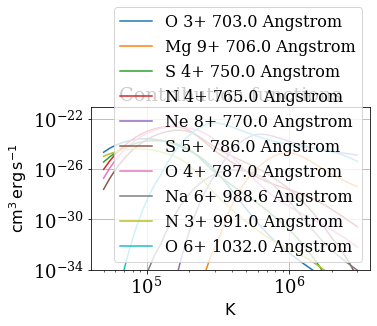

In [6]:
lines = ['O III', 'Mg IX', 'S IV', 'N IV', 'Ne VIII', 'S V', 'O IV', 'Na VI', 'N III', 'O VI']
#lines = ['O III','S IV', 'O IV', 'S V', 'N IV', 'Ne VIII', 'Mg IX']
#wvl =  [703 , 750, 787, 786, 765, 770, 706]
wvl = [703, 706, 750, 765, 770, 786, 787, 988.6, 991, 1032]
Te = np.geomspace(0.05e6, 3e6, 41)*u.K #* u.MK
ne = 1e8 * u.cm**-3

#Create dict with max density, wvl transitions and np.argmin(np.abs(transitions - wlen))
dict_contribution = {
    "Ion" : [],
    "Abundance" : [],
    "Max_density" : [],
    "Index" : [],
    "Function" : []}

plt.figure(figsize=(5,3))

for x in tqdm_notebook(range(len(lines))) :
    #Creating Ion object for each line
    ion = Ion(lines[x], Te)
    
    dict_contribution["Ion"].append(ion.ion_name)
    dict_contribution["Abundance"].append(ion.abundance.value)
    
    contribution_func = ion.contribution_function(ne)
    wlen = wvl[x] * u.Angstrom
    dict_contribution["Max_density"].append(contribution_func.max().value)
    

    transitions = ion.transitions.wavelength[~ion.transitions.is_twophoton]
    idx = np.argmin(np.abs(transitions - wlen))
    dict_contribution["Index"].append(idx)
    dict_contribution["Function"].append(contribution_func[:, 0, idx])
    
    plt.plot(Te, contribution_func[:, 0, idx],
         label=f'{ion.atomic_symbol} {ion.ionization_stage}+ {wlen}')
    plt.title('Contribution functions')
    plt.xscale('log'), plt.yscale('log'), 
    plt.ylim(10e-35, 10e-22)
    plt.legend(), plt.grid(visible=True)

plt.show()

# DEM computation

In [9]:
def DEM(file, amps, errs):
    if file == 82 : 
        file = "mosaic\\solo_L2_spice-n-ras_20220302T004014_V03_100663682-000.fits"
    elif file == 86 :
        file = "mosaic\\solo_L2_spice-n-ras_20220302T091034_V02_100663686-000.fits"
    elif file == 90 :
        file = "mosaic\\solo_L2_spice-n-ras_20220302T181034_V02_100663690-000.fits"
    exposure = read_spice_l2_fits(file, memmap=False)
    tot_err_nonan = []
    tot_amp_nonan = []
    rad_fac = 4*(180*3600)**2/0.1
    keys = ['O III 703 / Mg IX 706 - SH', 'O III 703 / Mg IX 706 - SH','S IV 750/ Mg IX (spectral bin 2)', 'N IV 765 - Peak',
        'Ne VIII 770 / Mg VIII 772 - SH',  'S V 786 / O IV 787 - LW',
        'S V 786 / O IV 787 - LW', 'N III 991 - SH', 'N III 991 - SH', 'O VI 1032 - Peak']
    for k in range(len(amps)):
        B = np.nan_to_num( np.array(errs[k]), nan = np.nanmax(errs[k]),
                          posinf=np.nanmax(errs[k]), neginf=np.nanmax(errs[k]))
        B[ B == 0] = np.nanmax(errs[k])
        tot_err_nonan.append(B*rad_fac)
        A = np.nan_to_num(np.array(amps[k]), nan = 0.01,
                          posinf=0.01, neginf=0.01)
        A[ A == 0] = 0.01
        tot_amp_nonan.append(A*rad_fac)
    

    for i in range((len(tot_amp_nonan))):
        raster = exposure[keys[i]]
        tot_amp_nonan[i] = NDCube(tot_amp_nonan[i], wcs = raster[0,0].wcs, meta = {"detector": "SPICE",
                                                                                   "wave_str" :list(exposure.keys())[i],
                                                                                   "exptime": 20})
    logt_arr = np.arange(4.5,6.55,0.05)
    logts = []
    for i in range(trespsCorona.shape[0]):
        logts.append(logt_arr)

    #Time exposure for each spectral line
    exptimes = np.array([20,20,20,20,20])

    #Turning list of fitted amplitude into usable object (datasequence)
    datasequence = emtk.em_data(tot_amp_nonan, tot_err_nonan, logts, trespsCorona)
    em_collection = emtk.em_collection(datasequence)

    coeffs,logts,bases,wcs,algorithm, chi2 = simple_reg_dem_wrapper(em_collection.data())
    demsequence = emtk.dem_model(coeffs,logts,bases,wcs,algorithm,simple_reg_dem_wrapper)
    em_collection.add_model(demsequence)

    demmax = 5.0e28
    gfac = 1.0/2.2
    dem = []
    for i in range(len(demsequence.data)):
        dem.append(demsequence[i,:,:].data)
    dems = np.dstack(dem)
    return dems

In [10]:
dem82 = DEM(82,fitamps82, fiterr82)
dem86 = DEM(86,fitamps86, fiterr86)
dem90 = DEM(90,fitamps90, fiterr90)

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
41


  0%|          | 0/162 [00:00<?, ?it/s]

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
41


  0%|          | 0/192 [00:00<?, ?it/s]

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
41


  0%|          | 0/160 [00:00<?, ?it/s]

In [68]:
bin_facs = np.array([1, 2, 1])
def substract_min_cube(cube):
    det_plane_min = np.nanmin(cube,axis=0)
    print(cube.shape[0])
    for i in range(0,cube.shape[0]): 
        cube[i,:,:] -= det_plane_min
    return cube

def bindown(d,n):
    inds = np.ravel_multi_index(np.floor((np.indices(d.shape).T*n/np.array(d.shape))).T.astype(np.uint32),n)
    return np.bincount(inds.flatten(),weights=d.flatten(),minlength=np.prod(n)).reshape(n)    
data_path = "mosaic"
filename = "solo_L2_spice-n-ras_20220302T091034_V02_100663686-000.fits"
file = os.path.join(data_path, filename)
exposure = read_spice_l2_fits(file,memmap=False)
key = 'O VI 1032 - Peak'
raster = exposure['O VI 1032 - Peak']


wvl = raster.spectral_axis.to(u.Angstrom)
if '82-' in file :
    print("crop 82")
    print('Raster shape : ',exposure[key].data.shape)
    raster = exposure[key][:,:,100:711,30:]
else :
    print('Raster shape : ',exposure[key].data.shape)
    raster = exposure[key][:,:,100:711,:]
cube = raster[0].data.transpose([2,1,0])
cube = substract_min_cube(cube)

Raster shape :  (1, 17, 834, 192)
192


# FIP bias with DEM inversion
### $FIP_{Bias} = \frac{I_{LF}}{I_{HF}}(\frac{A^P_{LF}}{A^P_{HF}}\frac{<C_{LF}, DEM>}{<C_{HF}, DEM>})^{-1}$

In [11]:
ionNe = Ion(ions[3], Te, 'sun_photospheric_2015_scott')
ionMg = Ion(ions[1], Te, 'sun_photospheric_2015_scott')

In [72]:
dem82

array([[[8.30312210e+21, 8.30312210e+21, 8.30312210e+21, ...,
         8.30312210e+21, 8.30312210e+21, 8.30312210e+21],
        [1.14570607e+22, 1.14570607e+22, 1.14570607e+22, ...,
         1.14570607e+22, 1.14570607e+22, 1.14570607e+22],
        [1.12686513e+22, 1.12686513e+22, 1.12686513e+22, ...,
         1.12686513e+22, 1.12686513e+22, 1.12686513e+22],
        ...,
        [8.95909565e+21, 8.95909565e+21, 8.95909565e+21, ...,
         8.95909565e+21, 8.95909565e+21, 8.95909565e+21],
        [9.79249354e+21, 9.79249354e+21, 9.79249354e+21, ...,
         9.79249354e+21, 9.79249354e+21, 9.79249354e+21],
        [1.05096242e+22, 1.05096242e+22, 1.05096242e+22, ...,
         1.05096242e+22, 1.05096242e+22, 1.05096242e+22]],

       [[8.76835584e+21, 8.76835584e+21, 8.76835584e+21, ...,
         8.76835584e+21, 8.76835584e+21, 8.76835584e+21],
        [1.07365731e+22, 1.07365731e+22, 1.07365731e+22, ...,
         1.07365731e+22, 1.07365731e+22, 1.07365731e+22],
        [1.07259164e+22, 

In [76]:
FIP_bias_CLR82Ne = np.zeros((ampsMgIX82.shape[0],ampsMgIX82.shape[1]))
for i in tqdm_notebook(range(ampsMgIX82.shape[0])):
    for j in range(ampsMgIX82.shape[1]):
        pd_scalMg = np.sum(dict_contribution["Function"][1]*dem82[i,j,:]) #np.sum
        pd_scalNe = np.sum(dict_contribution["Function"][3]*dem82[i,j,:])
        FIP_bias_CLR82Ne[i][j] = (ampsMgIX82[i][j]/ampsNe82[i][j])*((ionMg.abundance/ionNe.abundance)*(pd_scalMg/pd_scalNe))**(-1)

FIP_bias_CLR86Ne = np.zeros((ampsMgIX86.shape[0],ampsMgIX86.shape[1]))
for i in range(ampsMgIX86.shape[0]):
    for j in range(ampsMgIX86.shape[1]):
        pd_scalMg = np.sum(dict_contribution["Function"][1]*dem86[i,j,:])
        pd_scalNe = np.sum(dict_contribution["Function"][3]*dem86[i,j,:])
        FIP_bias_CLR86Ne[i][j] = (ampsMgIX86[i][j]/ampsNe86[i][j])*((ionMg.abundance/ionNe.abundance)*(pd_scalMg/pd_scalNe))**(-1)

  0%|          | 0/162 [00:00<?, ?it/s]

In [75]:
FIP_bias_CLR90Ne = np.zeros((ampsMgIX90.shape[0],ampsMgIX90.shape[1]))
for i in range(ampsMgIX90.shape[0]):
    for j in range(ampsMgIX90.shape[1]):
        pd_scalMg = np.sum(dict_contribution["Function"][1]*dem90[i,j,:])
        pd_scalNe = np.sum(dict_contribution["Function"][3]*dem90[i,j,:])
        FIP_bias_CLR90Ne[i][j] = (ampsMgIX90[i][j]/ampsNe90[i][j])*((ionMg.abundance/ionNe.abundance)*(pd_scalMg/pd_scalNe))**(-1)  

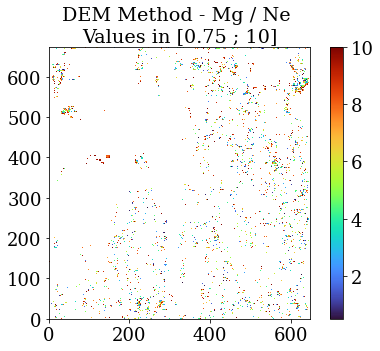

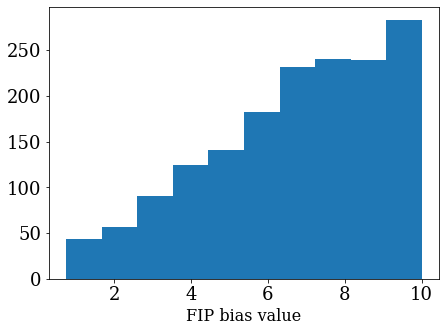

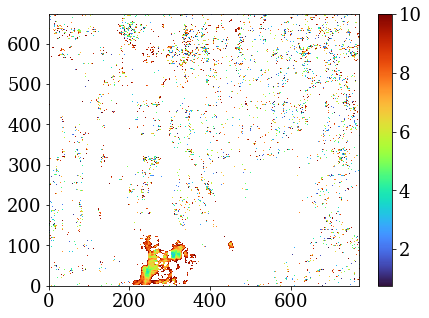

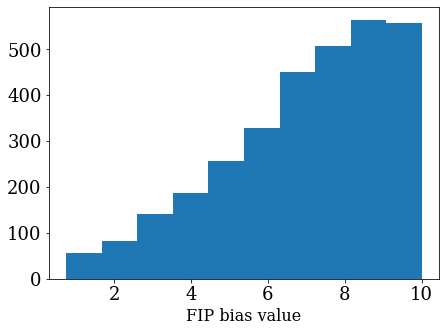

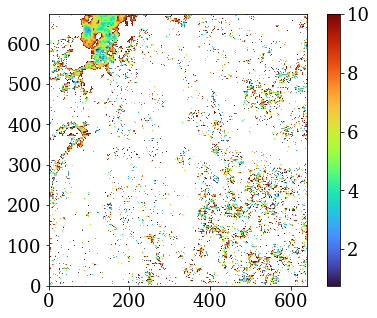

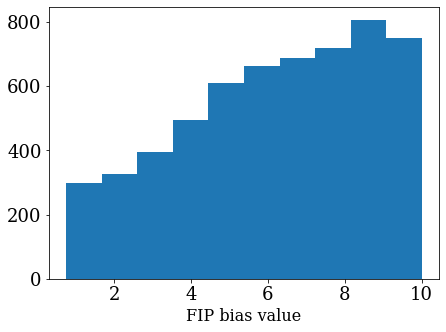

((array([297., 326., 394., 495., 611., 664., 686., 719., 806., 751.]),
  array([ 0.75 ,  1.675,  2.6  ,  3.525,  4.45 ,  5.375,  6.3  ,  7.225,
          8.15 ,  9.075, 10.   ]),
  <BarContainer object of 10 artists>),
 Text(0.5, 24.200000000000003, 'FIP bias value'),
 None)

In [77]:
plt.figure(figsize=[7,5])
im = plt.imshow((FIP_bias_CLR82Ne.T), extent=extent82, cmap='turbo', vmin=0.75, vmax=10)
plt.colorbar()
im.set_clim(0.5, 10)
im.cmap.set_over('white'), im.cmap.set_under('white')
plt.title('DEM Method - Mg / Ne \nValues in [0.75 ; 10]')
plt.show()
plt.hist(((FIP_bias_CLR82Ne.T)).flatten(), range = (0.75,10)), plt.xlabel('FIP bias value'), plt.show()

plt.figure(figsize=[7,5])
plt.imshow((FIP_bias_CLR86Ne.T), extent=extent86, cmap='turbo', vmin=0.75, vmax=10), plt.colorbar()
im.set_clim(1, 10)
im.cmap.set_over('white'), im.cmap.set_under('white')
plt.show()
plt.hist(((FIP_bias_CLR86Ne.T)).flatten(), range = (0.75,10)), plt.xlabel('FIP bias value'), plt.show()

plt.figure(figsize=[7,5])
plt.imshow((FIP_bias_CLR90Ne.T), extent=extent90, cmap='turbo', vmin=0.75, vmax=10), plt.colorbar()
im.set_clim(0.5, 10)
im.cmap.set_over('white'), im.cmap.set_under('white')
plt.show()
plt.hist(((FIP_bias_CLR90Ne.T)).flatten(), range = (0.75,10)), plt.xlabel('FIP bias value'), plt.show()

In [26]:
ionOVI = Ion(lines[7], Te, 'sun_photospheric_2015_scott')
ionSV = Ion(lines[5], Te, 'sun_photospheric_2015_scott')

In [35]:
FIP_bias_CLR82 = np.zeros((ampsSV82.shape[0],ampsSV82.shape[1]))
for i in tqdm_notebook(range(ampsSV82.shape[0])):
    for j in range(ampsSV82.shape[1]):
        pd_scalSV = np.trapz(dict_contribution["Function"][5]*dem82[i,j,:], x = Te.value)
        pd_scalOVI = np.trapz(dict_contribution["Function"][7]*dem82[i,j,:], x = Te.value)
        FIP_bias_CLR82[i][j] = (ampsSV82[i][j]/ampsOVI82[i][j])*((ionSV.abundance/ionOVI.abundance)*(pd_scalSV/pd_scalOVI))**(-1)
        

FIP_bias_CLR86 = np.zeros((ampsSV86.shape[0],ampsSV86.shape[1]))
for i in range(ampsSV86.shape[0]):
    for j in range(ampsSV86.shape[1]):
        pd_scalSV = np.trapz(dict_contribution["Function"][5]*dem86[i,j,:], x = Te.value)
        pd_scalOVI = np.trapz(dict_contribution["Function"][7]*dem86[i,j,:], x = Te.value)
        FIP_bias_CLR86[i][j] = (ampsSV86[i][j]/ampsOVI86[i][j])*((ionSV.abundance/ionOVI.abundance)*(pd_scalSV/pd_scalOVI))**(-1)

FIP_bias_CLR90 = np.zeros((ampsSV90.shape[0],ampsSV90.shape[1]))
for i in range(ampsSV90.shape[0]):
    for j in range(ampsSV90.shape[1]):
        pd_scalSV = np.trapz(dict_contribution["Function"][5]*dem90[i,j,:], x = Te.value)
        pd_scalOVI = np.trapz(dict_contribution["Function"][7]*dem90[i,j,:], x = Te.value)
        FIP_bias_CLR90[i][j] = (ampsSV90[i][j]/ampsOVI90[i][j])*((ionSV.abundance/ionOVI.abundance)*(pd_scalSV/pd_scalOVI))**(-1)

  0%|          | 0/162 [00:00<?, ?it/s]

In [36]:
FIP_bias_CLR90

array([[-6.57120095e-05,  7.33264327e-05,  7.04391783e-05, ...,
                    inf, -7.98538162e-05,            -inf],
       [-9.76053739e-05,  6.64512774e-05,  7.45973140e-05, ...,
         4.83154723e-04,            -inf,            -inf],
       [-7.43337808e-05,  6.29351109e-05,  5.96314427e-05, ...,
         9.72315379e-04,            -inf,            -inf],
       ...,
       [-5.42070376e-05, -2.71409355e-05,  2.25196017e-05, ...,
         1.31486963e-04,  1.55151023e-04,  1.16323283e-04],
       [-7.85580982e-05, -6.98097703e-05,  4.95823029e-05, ...,
         8.27005665e-05,  1.00928991e-04,  1.12697279e-04],
       [           -inf, -7.06233991e-05, -3.16215094e-05, ...,
         5.82794997e-05,  7.36472473e-05,  8.83212945e-05]])

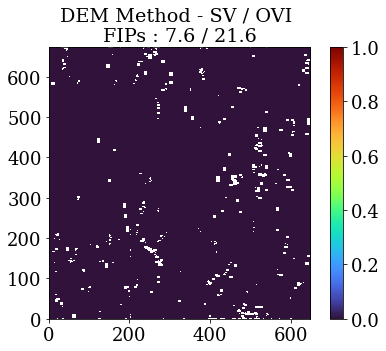

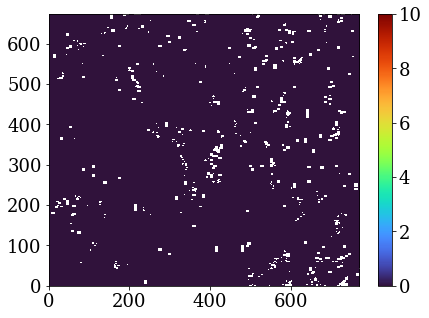

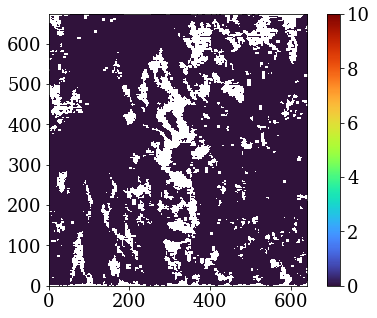

In [69]:
plt.figure(figsize=[7,5])
plt.imshow((FIP_bias_CLR82.T), extent=extent82, cmap='turbo', vmin=0, vmax=1), plt.colorbar()
plt.title('DEM Method - SV / OVI \nFIPs : 7.6 / 21.6')
plt.show()

plt.figure(figsize=[7,5])
plt.imshow(FIP_bias_CLR86.T, extent=extent86, cmap='turbo', vmin=0, vmax=10), plt.colorbar()
plt.show()

plt.figure(figsize=[7,5])
plt.imshow(FIP_bias_CLR90.T, extent=extent90, cmap='turbo', vmin=0, vmax=10), plt.colorbar()
plt.show()

In [ ]:
amps_SIV_86 = amps_clip(fit_amps2G_86[1])
amps_OIII_86 = amps_clip(fit_ampsOIII_86)
amps_SIV_82 = amps_clip(fit_amps2G_82[1])
amps_OIII_82 = amps_clip(fit_ampsOIII_82)
amps_SIV_90 = amps_clip(fit_amps2G_90[1])
amps_OIII_90 = amps_clip(fit_ampsOIII_90);

In [ ]:
data_path = "mosaic"
filename = "solo_L2_spice-n-ras_20220302T091034_V02_100663686-000.fits"
file = os.path.join(data_path, filename)
exposure = read_spice_l2_fits(file,memmap=False)
raster86 = exposure[list(exposure.keys())[0]]
filename = "solo_L2_spice-n-ras_20220302T004014_V03_100663682-000.fits"
file = os.path.join(data_path, filename)
exposure = read_spice_l2_fits(file,memmap=False)
raster82 = exposure[list(exposure.keys())[0]]
filename = "solo_L2_spice-n-ras_20220302T181034_V02_100663690-000.fits"
file = os.path.join(data_path, filename)
exposure = read_spice_l2_fits(file,memmap=False)
raster90 = exposure[list(exposure.keys())[0]]

In [20]:
extent90 = [0, 192*raster90.wcs.wcs.cdelt[0], 0, raster90.wcs.wcs.cdelt[1]*2*306]
extent86 = [0, 192*raster86.wcs.wcs.cdelt[0], 0, raster86.wcs.wcs.cdelt[1]*2*306]
extent82 = [0, 162*raster82.wcs.wcs.cdelt[0], 0, raster82.wcs.wcs.cdelt[1]*2*306]

NameError: name 'raster90' is not defined

# FIP bias SIV / OIII - non normalized

In [ ]:
ionOIII = Ion(lines[0], Te, 'sun_photospheric_2015_scott')
ionSIV = Ion(lines[1], Te, 'sun_photospheric_2015_scott')

print(np.mean(amps_OIII_82), np.mean(amps_OIII_86), np.mean(amps_OIII_90))
print(np.mean(amps_SIV_82), np.mean(amps_SIV_86), np.mean(amps_SIV_90))

fip_biasSIV_OIII86 = (amps_SIV_86[:,50:356]/amps_OIII_86[:,50:356])*(ionSIV.abundance/ionOIII.abundance)*(max_contrib_func[1]/max_contrib_func[0])
fip_biasSIV_OIII86 = np.nan_to_num(fip_biasSIV_OIII86, posinf=0, neginf=0, nan=0)    

fip_biasSIV_OIII82 = (amps_SIV_82[30:,50:356]/amps_OIII_82[30:,50:356])*(ionSIV.abundance/ionOIII.abundance)*(max_contrib_func[1]/max_contrib_func[0])
fip_biasSIV_OIII82 = np.nan_to_num(fip_biasSIV_OIII82, posinf=0, neginf=0, nan=0) 

fip_biasSIV_OIII90 = (amps_SIV_90[:,50:356]/amps_OIII_90)*(ionSIV.abundance/ionOIII.abundance)*(max_contrib_func[1]/max_contrib_func[0])
fip_biasSIV_OIII90 = np.nan_to_num(fip_biasSIV_OIII90, posinf=0, neginf=0, nan=0) 

# NIV SV - non normalized

In [ ]:
ampsNIV86 = fit_amps1G_86[0][:,50:356]
ampsSV86 = fit_amps2G_86[0][:,50:356]
ampsNIV82 = fit_amps1G_82[0][:,50:356]
ampsSV82 = fit_amps2G_82[0][:,50:356]
ampsNIV90 = fit_amps1G_90[0][:,50:356]
ampsSV90 = fit_amps2G_90[0][:,50:356]
ionSV = Ion(lines[3], Te, 'sun_photospheric_2015_scott')
ionNIV = Ion(lines[4], Te, 'sun_photospheric_2015_scott')

# SV N IV - Normalized

In [ ]:
ampsNIV86 = fit_amps1G_86[0][:,50:356]/val_clip(fit_amps1G_86[0][:,50:356])
ampsSV86 = fit_amps2G_86[0][:,50:356]/val_clip(fit_amps2G_86[0][:,50:356])
ampsNIV82 = fit_amps1G_82[0][:,50:356]/val_clip(fit_amps1G_82[0][:,50:356])
ampsSV82 = fit_amps2G_82[0][:,50:356]/val_clip(fit_amps2G_82[0][:,50:356])
ampsNIV90 = fit_amps1G_90[0][:,50:356]/val_clip(fit_amps1G_90[0][:,50:356])
ampsSV90 = fit_amps2G_90[0][:,50:356]/val_clip(fit_amps2G_90[0][:,50:356])

# Ne Mg

In [ ]:
amps_ne_82 = fit_amps1G_82[1][30:,50:356]
amps_mg_82 = fit_ampsMg_82[30:,50:356]
amps_ne_86 = fit_amps1G_86[1][:,50:356]
amps_mg_86 = fit_ampsMg_86[:,50:356]
amps_ne_90 = fit_amps1G_90[1][:,50:356]
amps_mg_90 = fit_ampsMg_90

ionNe = Ion(lines[5], Te, 'sun_photospheric_2015_scott')
ionMg = Ion(lines[6], Te, 'sun_photospheric_2015_scott')

print(amps_ne_82.shape, amps_mg_82.shape, amps_ne_86.shape, amps_mg_86.shape, amps_ne_90.shape, amps_mg_90.shape)